In [1]:
from glob import glob 
import numpy as np 
import xarray as xr
import rioxarray

# find all nc files
files = glob("../data/raw/**/*.nc",recursive=True)

for f in files:
    print(f)

../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19891201-19901130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19821201-19831130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19841201-19851130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19871201-19881130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19811201-19821130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19881201-19891130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19831201-19841130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19851201-19861130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19861201-19871130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc


In [2]:
f0 = files[0]

## Conversion

In [3]:
# Don't need the extra dims - AFAIK
ncfile = xr.open_dataset(f0).drop_dims("bnds").squeeze()
ncfile = ncfile.rio.set_spatial_dims('grid_longitude', 'grid_latitude')
ncfile.rio.write_crs("EPSG:4326", inplace=True)
del ncfile["tasmax"].attrs['grid_mapping'] # need to drop this too in order to size properly
f0_n = f0.replace(".nc","geotif.tif")
ncfile["tasmax"].rio.to_raster(f0_n)

This writing and reading again below is funstrating: 
TODO: fix so only a single save occurs

In [4]:
f0_rep = f0_n.replace(".tif","_reproj_.tif")
geotif = xr.open_dataset(f0_n, engine='rasterio')
geotif.rio.reproject("epsg:27700")['band_data'].rio.to_raster(f0_rep)
geotif = xr.open_dataset(f0_rep, engine='rasterio')
geotif

<xarray.Dataset>
Dimensions:      (band: 360, x: 492, y: 603)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
  * x            (x) float64 -5.259e+04 -5.023e+04 ... 1.101e+06 1.103e+06
  * y            (y) float64 -4.63e+06 -4.633e+06 ... -6.045e+06 -6.047e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [5]:
geotif.rio.crs

CRS.from_epsg(27700)

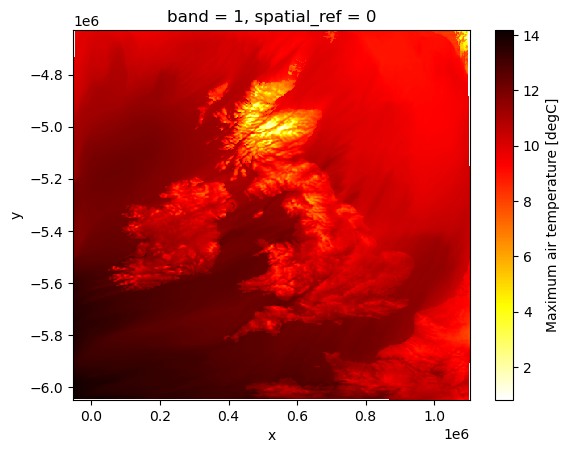

In [6]:
da = geotif.isel(band=0).band_data.expand_dims({"band":1})
# exclude vals below or equal to 0, squeeze to 2d and plot
da.where(da>=0).squeeze().plot.imshow(cmap="hot_r")

In [7]:
from os.path import basename

basename(f0)

'tasmax_rcp85_land-cpm_uk_2.2km_01_day_19891201-19901130.nc'